In [82]:
# cofing: utf-8
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow

In [83]:
# データの前処理
import os
import sklearn
import sklearn.model_selection
from tensorflow.keras.utils import to_categorical
batch_size = 100 # データの大きさ reshapeしてからshapeの形求める感じでやろう
timesteps = 256
input_dim = 3 # acc (x, y, z)
num_classes = 7 # 分類数

x_train, y_train, x_test, y_test = (1, 1, 1, 1)


In [84]:
# データの読み込み
home_dir = os.path.expanduser("~")
label_path = home_dir + "/Desktop/hasc_data/y_large3.csv"
data_path  = home_dir + "/Desktop/hasc_data/x_large3.csv"

label_df = pd.read_csv(label_path, index_col=0)
data_np  = np.loadtxt (data_path , delimiter=",").reshape(-1, timesteps, input_dim)

In [85]:
# label の取り扱い
# 0 to 5 :  6 class
labels = label_df["act"] - 1
print(labels)

0        0
1        0
2        0
3        0
4        0
        ..
36866    5
36867    5
36868    5
36869    5
36870    5
Name: act, Length: 36871, dtype: int64


In [ ]:
# データ分割

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(data_np, labels, test_size = 0.2, train_size=None, stratify=labels)

y_test = to_categorical(y_test)
y_train = to_categorical(y_train)

num_classes = len(labels.unique())
batch_size = x_train.shape[0]
print(num_classes, "classies validation")
print("train data len :", batch_size)
print("test  data len :", x_test.shape[0])

In [87]:
#preprocessing
# TODO
# ここもっと綺麗にしたい
# dict使って，MMSとStdSをうまく使えるようにしたい
from sklearn.preprocessing import MinMaxScaler, StandardScaler

MMScaler = MinMaxScaler()
StdScaler = StandardScaler()

datas = {"original" : [x_train, x_train]}
x_train_mms  = []
x_test_mms   = []
x_train_stds = []
x_test_stds  = []

for data in x_train:
    x = MMScaler.fit_transform(data)
    x_train_mms.append(x)
    x = StdScaler.fit_transform(data)
    x_train_stds.append(x)

for data in x_test:
    x = MMScaler.fit_transform(data)
    x_test_mms.append(x)
    x = StdScaler.fit_transform(data)
    x_test_stds.append(x)

x_train_mms  = np.array(x_train_mms )
x_test_mms   = np.array(x_test_mms  )
x_train_stds = np.array(x_train_stds)
x_test_stds  = np.array(x_test_stds )

datas["mms"] = [x_train_mms,  x_test_mms]
datas["stds"]= [x_train_stds, x_test_stds]


In [88]:
# TODO モデルを保存したdictを作ってうまく管理したい
# 今はモデル作ったやつをそのまま辞書の中に入れてるけど，コンパイルしてから入れたほうがいいかも？

models = {}

lstm_dontrun_input = Input( shape=( timesteps, input_dim ) )
lstm_dontrun_lstm1 = LSTM(units=256, activation="relu", kernel_initializer="he_normal", return_sequences=True, dropout=0.1)( lstm_dontrun_input )
lstm_dontrun_lstm2 = LSTM(units=128, activation="relu", kernel_initializer="he_normal", return_sequences=True, dropout=0.1)( lstm_dontrun_lstm1 )
lstm_dontrun_lstm3 = LSTM(units=64, activation="relu", kernel_initializer="he_normal",  return_sequences=True, dropout=0.1)( lstm_dontrun_lstm2 )
lstm_dontrun_lstm4 = LSTM(units=32, activation="relu", kernel_initializer="he_normal", dropout=0.1)( lstm_dontrun_lstm3 )
lstm_dontrun_dense = Dense(units=num_classes, activation="softmax")( lstm_dontrun_lstm4 )
model_lstm_dontrun = Model(inputs = lstm_dontrun_input, outputs=lstm_dontrun_dense, name="lstm_dontrun")
models["lstm_dontrun"] = model_lstm_dontrun

lstm_1_input = Input( shape=( timesteps, input_dim ) )
lstm_1_lstm = LSTM(units=32, activation="relu", kernel_initializer="he_normal",  return_sequences=False, dropout=0.1)( lstm_1_input )
lstm_1_dense = Dense(units=num_classes, activation="softmax")( lstm_1_lstm )
model_lstm_1 = Model(inputs = lstm_1_input, outputs = lstm_1_dense, name="lstm_1")
models["lstm_1"] = model_lstm_1

conv1_1_input = Input( shape=( timesteps, input_dim ) )
conv1_1_conv1 = Conv1D(filters=128, kernel_size=16, strides=1, padding='same', kernel_initializer="he_normal", activation="relu")(conv1_1_input)
conv1_1_pool1 = MaxPooling1D(4, padding='same')(conv1_1_conv1)
conv1_1_conv2 = Conv1D(filters=64, kernel_size=16, strides=1, padding='same', kernel_initializer="he_normal", activation="relu")(conv1_1_pool1)
conv1_1_pool2 = MaxPooling1D(1, padding='same')(conv1_1_conv2)
conv1_1_conv3 = Conv1D(filters=32, kernel_size=16, strides=1, padding='same', kernel_initializer="he_normal", activation="relu")(conv1_1_pool2)
conv1_1_conv4 = Conv1D(filters=16, kernel_size=16, strides=1, padding='same', kernel_initializer="he_normal", activation="relu")(conv1_1_conv3)
conv1_1_flatter = Flatten()(conv1_1_conv4)
conv1_1_dense = Dense(units=num_classes, activation="softmax")(conv1_1_flatter)
model_conv1_1 = Model(inputs=conv1_1_input, outputs=conv1_1_dense, name="conv1d_1")
models["conv1d_1"] = model_conv1_1



conv1_2_input = Input( shape=( timesteps, input_dim ) )
conv1_2_conv1 = Conv1D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer="he_normal", activation="relu")(conv1_2_input)
conv1_2_dropout1 = Dropout(0.25)(conv1_2_conv1)
# conv1_2_pool1 = MaxPooling1D(4, padding='same')(conv1_1_conv1)
conv1_2_conv2 = Conv1D(filters=128, kernel_size=3, strides=1, padding='same', kernel_initializer="he_normal", activation="relu")(conv1_2_dropout1)
conv1_2_dropout2 = Dropout(0.25)(conv1_2_conv2)
# conv1_2_pool2 = MaxPooling1D(1, padding='same')(conv1_1_conv2)
conv1_2_conv3 = Conv1D(filters=128, kernel_size=3, strides=1, padding='same', kernel_initializer="he_normal", activation="relu")(conv1_2_dropout2)
conv1_2_dropout3 = Dropout(0.25)(conv1_2_conv3)
conv1_2_conv4 = Conv1D(filters=256, kernel_size=3, strides=1, padding='same', kernel_initializer="he_normal", activation="relu")(conv1_2_dropout3)
conv1_2_dropout4 = Dropout(0.25)(conv1_2_conv4)
conv1_2_flatter = Flatten()(conv1_2_dropout4)
conv1_2_dense1 = Dense(units=2048, activation="relu")(conv1_2_flatter)
conv1_2_dense2 = Dense(units=num_classes, activation="softmax")(conv1_2_dense1)
model_conv1_2 = Model(inputs=conv1_2_input, outputs=conv1_2_dense2, name="conv1d_2")
models["conv1d_2"] = model_conv1_2


# 1d vgg16
vgg16_input = Input(shape=(timesteps, input_dim))

# block1
vgg16_block1_conv1 = Conv1D(filters=64, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_input)
vgg16_block1_bn1 = BatchNormalization()(vgg16_block1_conv1)
vgg16_block1_actiovation1 = Activation("relu")(vgg16_block1_bn1)
vgg16_block1_conv2 = Conv1D(filters=64, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block1_actiovation1)
vgg16_block1_bn2 = BatchNormalization()(vgg16_block1_conv2)
vgg16_block1_actiovation2 = Activation("relu")(vgg16_block1_bn2)
vgg16_block1_pool = MaxPooling1D(pool_size=2, strides=2, padding="same")(vgg16_block1_actiovation2)

# block2
vgg16_block2_conv1 = Conv1D(filters=128, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block1_pool)
vgg16_block2_bn1 = BatchNormalization()(vgg16_block2_conv1)
vgg16_block2_actiovation1 = Activation("relu")(vgg16_block2_bn1)
vgg16_block2_conv2 = Conv1D(filters=128, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block2_actiovation1)
vgg16_block2_bn2 = BatchNormalization()(vgg16_block2_conv2)
vgg16_block2_actiovation2 = Activation("relu")(vgg16_block2_bn2)
vgg16_block2_pool = MaxPooling1D(pool_size=2, strides=2, padding="same")(vgg16_block2_actiovation2)

# block3
vgg16_block3_conv1 = Conv1D(filters=256, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block2_pool)
vgg16_block3_bn1 = BatchNormalization()(vgg16_block3_conv1)
vgg16_block3_actiovation1 = Activation("relu")(vgg16_block3_bn1)
vgg16_block3_conv2 = Conv1D(filters=256, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block3_actiovation1)
vgg16_block3_bn2 = BatchNormalization()(vgg16_block3_conv2)
vgg16_block3_actiovation2 = Activation("relu")(vgg16_block3_bn2)
vgg16_block3_conv3 = Conv1D(filters=256, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block3_actiovation2)
vgg16_block3_bn3 = BatchNormalization()(vgg16_block3_conv3)
vgg16_block3_actiovation3 = Activation("relu")(vgg16_block3_bn3)
vgg16_block3_pool = MaxPooling1D(pool_size=2, strides=2, padding="same")(vgg16_block3_actiovation3)

# block4
vgg16_block4_conv1 = Conv1D(filters=512, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block3_pool)
vgg16_block4_bn1 = BatchNormalization()(vgg16_block4_conv1)
vgg16_block4_actiovation1 = Activation("relu")(vgg16_block4_bn1)
vgg16_block4_conv2 = Conv1D(filters=512, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block4_actiovation1)
vgg16_block4_bn2 = BatchNormalization()(vgg16_block4_conv2)
vgg16_block4_actiovation2 = Activation("relu")(vgg16_block4_bn2)
vgg16_block4_conv3 = Conv1D(filters=256, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block4_actiovation2)
vgg16_block4_bn3 = BatchNormalization()(vgg16_block4_conv3)
vgg16_block4_actiovation3 = Activation("relu")(vgg16_block4_bn3)
vgg16_block4_pool = MaxPooling1D(pool_size=2, strides=2, padding="same")(vgg16_block4_actiovation3)

# block5
vgg16_block5_conv1 = Conv1D(filters=512, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block4_pool)
vgg16_block5_bn1 = BatchNormalization()(vgg16_block5_conv1)
vgg16_block5_actiovation1 = Activation("relu")(vgg16_block5_bn1)
vgg16_block5_conv2 = Conv1D(filters=512, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block5_actiovation1)
vgg16_block5_bn2 = BatchNormalization()(vgg16_block5_conv2)
vgg16_block5_actiovation2 = Activation("relu")(vgg16_block5_bn2)
vgg16_block5_conv3 = Conv1D(filters=256, kernel_size=3, strides=1, padding="same", kernel_initializer="he_normal")(vgg16_block5_actiovation2)
vgg16_block5_bn3 = BatchNormalization()(vgg16_block5_conv3)
vgg16_block5_actiovation3 = Activation("relu")(vgg16_block5_bn3)
vgg16_block5_pool = MaxPooling1D(pool_size=2, strides=2, padding="same")(vgg16_block5_actiovation3)

# dense
vgg16_flatten = Flatten()(vgg16_block5_pool)
vgg16_dense1  = Dense(units=4096, activation="relu")(vgg16_flatten)
vgg16_dense2  = Dense(units=4096, activation="relu")(vgg16_dense1)
vgg16_output  = Dense(units=num_classes, activation="softmax")(vgg16_dense2)
model_vgg16_1d = Model(inputs = vgg16_input, outputs=vgg16_output, name="vgg16_1d")
models["vgg16_1d"] = model_vgg16_1d

In [89]:
print("model list:")
for name in models.keys():
    print("・", name)

for model in models.values():
    print()
    model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
    print()

model list:
・ lstm_dontrun
・ lstm_1
・ conv1d_1
・ conv1d_2
・ vgg16_1d

Model: "lstm_dontrun"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 256, 3)]          0         
_________________________________________________________________
lstm_45 (LSTM)               (None, 256, 256)          266240    
_________________________________________________________________
lstm_46 (LSTM)               (None, 256, 128)          197120    
_________________________________________________________________
lstm_47 (LSTM)               (None, 256, 64)           49408     
_________________________________________________________________
lstm_48 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_62 (Dense)             (None, 6)                 198       
Total params: 525,382
Trainable params: 525,382
No

In [90]:
"""
model_to_dotがうまく動かないのでこのセルは実行しないこと

from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog="dot", format="svg"))
"""

pass

In [93]:
# model_lstm.fit(x_train_mms, y_train, batch_size=batch_size//20, epochs=50, verbose=1, callbacks=[EarlyStopping(verbose=1)], validation_data=(x_test_mms, y_test))
# result = models["vgg16_1d"].fit(x_train_mms, y_train, batch_size=batch_size//20, epochs=50, verbose=1, validation_data=(x_test_mms, y_test))
result = models["vgg16_1d"].fit(datas["stds"][0], y_train, batch_size=batch_size//20, epochs=50, verbose=1, validation_data=(datas["stds"][1], y_test))


Train on 29496 samples, validate on 7375 samples
Epoch 1/50


KeyboardInterrupt: 

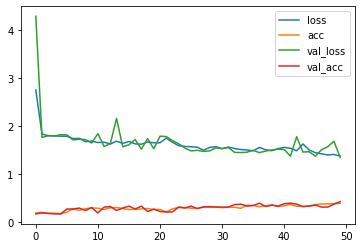

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
for key in  result.history.keys():
    plt.plot(result.history[key], label = key)
    plt.legend()

In [81]:
evals = models["vgg16_1d"].evaluate(x_test, y_test)
print("loss", evals[0])
print("acc",  evals[1])

98/98 [==============================] - 0s 4ms/sample - loss: 1.8222 - acc: 0.3061
loss 1.8222089592291384
acc 0.30612245
